#### Library imports and data imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
import pickle
from tqdm.autonotebook import tqdm
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import warnings
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from networkx.generators.degree_seq import expected_degree_graph
warnings.simplefilter(action='ignore', category=FutureWarning)

F:\Anaconda\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
author_df = pd.read_csv("data/four_area/author.txt", sep = "\t", names=["ID", "Author name"],encoding='utf8')
conf_df = pd.read_csv("data/four_area/conf.txt", sep = "\t", names=["ID", "Conference name"])
paper_df = pd.read_csv("data/four_area/paper.txt", sep = "\t", names=["ID", "Paper title"])
term_df = pd.read_csv("data/four_area/term.txt", sep = "\t", names=["ID", "Term"])
paper_author = pd.read_csv("data/four_area/paper_author.txt", sep = "\t", names=["paperID", "authorID"])
paper_conf = pd.read_csv("data/four_area/paper_conf.txt", sep = "\t", names=["paperID", "confID"])
paper_term = pd.read_csv("data/four_area/paper_term.txt", sep = "\t", names=["paperID", "termID"])
author_dict = pd.read_csv("data/DBLP_four_area/cleaned_author_dict.txt", sep = "\t", names=["ID", "Author name"], encoding='utf8')
conf_dict = pd.read_csv("data/DBLP_four_area/conf_dict.txt", sep = "\t", names=["ID", "Conference name"])
term_dict = pd.read_csv("data/DBLP_four_area/term_dict.txt", sep = "\t", names=["ID", "Term"])
author_label = pd.read_csv("data/DBLP_four_area/author_label.txt", sep = "\t", names=["authorID", "Label"])
conf_label = pd.read_csv("data/DBLP_four_area/conf_label.txt", sep = "\t", names=["confID", "Conference name", "Label"])

# Merging dataframes together
conf_dict_m = pd.merge(conf_dict, conf_df, on='Conference name')
author_dict_m = pd.merge(author_dict, author_df, on='Author name')
paper_conf_m = pd.merge(conf_dict_m, paper_conf, left_on='ID_y', right_on='confID')
paper_conf_m = paper_conf_m.drop(columns=['Conference name', 'ID_y','confID'])
paper_label_m = pd.merge(paper_conf_m, conf_label, left_on='ID_x', right_on='confID')
paper_label_m = paper_label_m.drop(columns=['Conference name', 'ID_x','confID'])
author_paper_label_m = pd.merge(paper_label_m,paper_author,on='paperID')

#### Code block to generate author_feature on the fly. We have included a pickle file to skip this step

In [3]:
# author_feature is a dataframe, 
# with column header being 'label', row index being 'author id', 
# and cell value being the number of papers that the coresponding author has written,
# for the corresponding labeled venue. 
# Example: Cell [1, 1] = 93, meaning author 1 has written 93 paper belonging to label 1 venues. 

# author_feature= pd.DataFrame(np.zeros(shape=(28702,4)),
#                               columns=[1,2,3,4],
#                               index=author_dict['ID'].unique()
#                          )
# for author in tqdm(author_paper_label_m['authorID'].unique()):
#     author_dict_ID = int(author_dict_m[author_dict_m["ID_y"] == author]['ID_x'].to_string(index=False).strip())
#     value_count = author_paper_label_m[author_paper_label_m['authorID'] == author]['Label'].value_counts()
#     for vc in value_count.iteritems():
#         label = vc[0]
#         count = vc[1]
#         author_feature.at[author_dict_ID, label]=count

In [4]:
# author_feature is a dataframe, 
# with column header being 'label', row index being 'author id', 
# and cell value being the number of papers that the coresponding author has written,
# for the corresponding labeled venue. 
# Example: Cell [1, 1] = 93, meaning author 1 has written 93 paper belonging to label 1 venues.
author_feature = pd.read_pickle('./author_feature.pickle')

#### Code block to generate author_features on the fly. We have included a pickle file to skip this step.
#### author_features is different from author_feature. It filtered out all non-labeled data, and included the actual features we need to train on. We will be only using author_features for the rest of the codes.

In [5]:
# author_features = author_feature.loc[author_label['authorID'],:]
# author_sum = np.sum(author_feature, axis = 1)
# author_features['sum'] = author_sum
# author_features['lgt_median'] = author_sum > 2
# author_features['lgt_mean'] = author_sum > 5
# author_features['DB_lgt_0'] = author_features[1]  > 0
# author_features['DM_lgt_0'] = author_features[2]  > 0
# author_features['ML_lgt_0'] = author_features[3]  > 0
# author_features['IR_lgt_0'] = author_features[4]  > 0

# author_features['DB_lgt_0.25'] = author_features[1] / author_features['sum'] > 0.25
# author_features['DM_lgt_0.25'] = author_features[2] / author_features['sum'] > 0.25
# author_features['ML_lgt_0.25'] = author_features[3] / author_features['sum'] > 0.25
# author_features['IR_lgt_0.25'] = author_features[4] / author_features['sum'] > 0.25

# author_features['co_1'] = 0
# author_features['co_2'] = 0    
# author_features['co_3'] = 0    
# author_features['co_4'] = 0    

# for index, row in tqdm(author_features.iterrows()):
#     adid = index
#     aid = int(author_dict_m[author_dict_m["ID_x"] == adid]['ID_y'].to_string(index=False).strip())
#     all_paper = paper_author[paper_author['authorID'] == aid]['paperID']
#     coauthor = []
#     for paper in all_paper:
#         authors = paper_author[paper_author['paperID'] == paper]['authorID']
#         authors = authors[authors != aid]
#         coauthor = np.concatenate((coauthor, authors))
#     coauthor = np.unique(coauthor)
#     coauthor_hashed = author_dict_m[author_dict_m['ID_y'].isin(coauthor)]['ID_x']
#     vc = author_label[author_label['authorID'].isin(coauthor_hashed)]['Label'].value_counts()
#     author_features.loc[adid, 'co_1']  += vc[1] if 1 in vc.index else 0
#     author_features.loc[adid, 'co_2']  += vc[2] if 2 in vc.index else 0    
#     author_features.loc[adid, 'co_3']  += vc[3] if 3 in vc.index else 0    
#     author_features.loc[adid, 'co_4']  += vc[4] if 4 in vc.index else 0    
    
# author_features['DB_co'] = author_features['co_1'] > 0
# author_features['DM_co'] = author_features['co_2'] > 0    
# author_features['ML_co'] = author_features['co_3'] > 0    
# author_features['IR_co'] = author_features['co_4'] > 0   

# author_features = pd.merge(author_features, author_label, left_index = True, right_on='authorID')

In [6]:
author_features = pd.read_pickle('./author_features.pickle')

### Variables of the MRF: 
1. (Number of papers by the author) > 2 (median)
2. (Number of papers by the author) > 5 (mean)
3. Percentage of DB paper > 0.25
4. Percentage of DM paper > 0.25
5. Percentage of ML paper > 0.25
6. Percentage of IR paper > 0.25
7. Co-authored with known DB authors 
8. Co-authored with known DM authors
9. Co-authored with known ML authors
10. Co-authored with known IR authors


In [7]:
acc=[]

In [8]:
for size in [0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    X = author_features[['lgt_median', 'lgt_mean', 'DB_lgt_0', 'DM_lgt_0', 'ML_lgt_0', 'IR_lgt_0',
                    'DB_lgt_0.25', 'DM_lgt_0.25', 'ML_lgt_0.25', 'IR_lgt_0.25', 
                    'DB_co', 'DM_co', 'ML_co', 'IR_co']].to_numpy()
    y = author_features[['Label']].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-size, random_state=42)
    bnb = BernoulliNB()
    y_pred = bnb.fit(X_train, y_train.ravel()).predict(X_test)
    score = 0
    for i in range(len(y_test)):
        score += (y_test[i] == y_pred[i])
    
    acc.append( score[0] / X_test.shape[0])

In [9]:
acc

[0.9148783977110158,
 0.9282273603082851,
 0.929423217327817,
 0.9269731989181215,
 0.9294409937888198,
 0.930763178599528,
 0.9280023605783417,
 0.9288604180714768,
 0.9284028324154209,
 0.9225684608120869,
 0.9227138643067847,
 0.9150275373721479]

Text(0, 0.5, 'Accuracy')

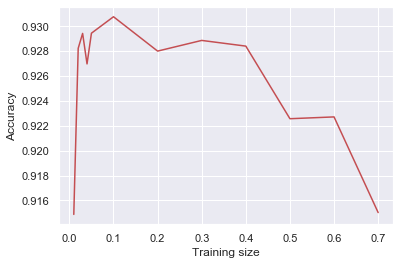

In [10]:
plt.plot([0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7],acc,'r-')
plt.xlabel('Training size')
plt.ylabel('Accuracy')

In [15]:
acc1 = acc[2:]

In [11]:
acc2 = [0.9338, 0.9187, 0.9172, 0.93341, 0.9338, 0.9289, 0.9392, 0.9088, 0.9178,0.9358]

In [12]:
acc3 = [0.9135, 0.9154, 0.9142, 0.922, 0.9296, 0.9326, 0.9462, 0.9506, 0.9623, 0.9749]

In [13]:
label = [0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7]

In [16]:
np.array([label, acc1, acc2, acc3]).T

array([[0.03      , 0.92942322, 0.9338    , 0.9135    ],
       [0.04      , 0.9269732 , 0.9187    , 0.9154    ],
       [0.05      , 0.92944099, 0.9172    , 0.9142    ],
       [0.1       , 0.93076318, 0.93341   , 0.922     ],
       [0.2       , 0.92800236, 0.9338    , 0.9296    ],
       [0.3       , 0.92886042, 0.9289    , 0.9326    ],
       [0.4       , 0.92840283, 0.9392    , 0.9462    ],
       [0.5       , 0.92256846, 0.9088    , 0.9506    ],
       [0.6       , 0.92271386, 0.9178    , 0.9623    ],
       [0.7       , 0.91502754, 0.9358    , 0.9749    ]])

In [17]:
df = pd.DataFrame(np.array([label, acc1, acc2, acc3]).T,
                   columns=['Trainset Portion','Accuracy for Model 1', 'Accuracy for Model 2', 'Accuracy for Model 3'])

In [18]:
df2 = pd.melt(df, id_vars="Trainset Portion", var_name="Model", value_name="Accuracy")

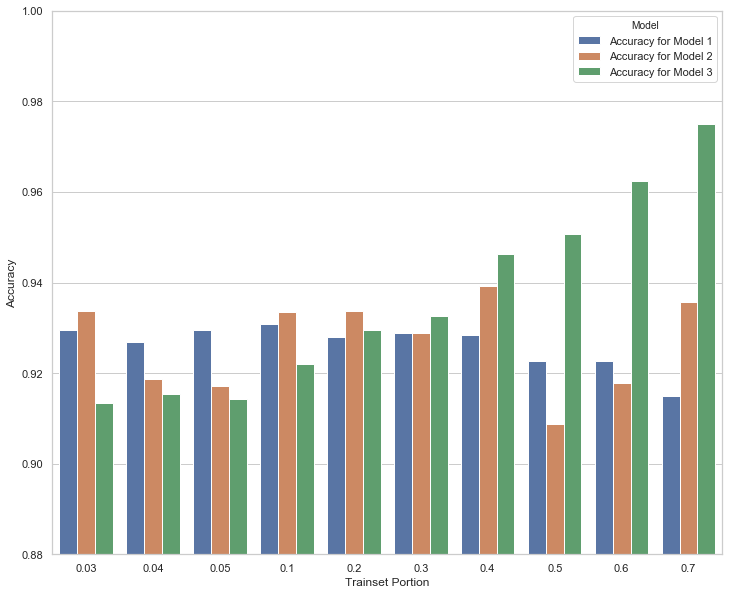

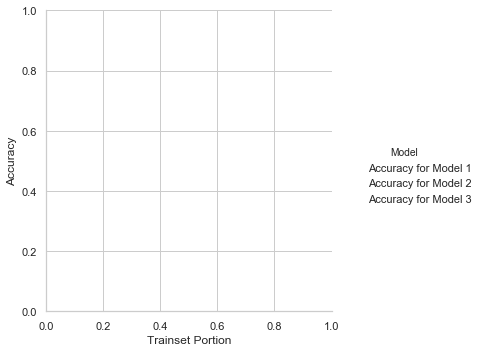

In [20]:
fig, ax = plt.subplots(figsize=(12,10))
plt.ylim(0.88, 1)
sns.set_style("whitegrid")
sns.catplot(ax = ax, x='Trainset Portion', y='Accuracy', hue='Model',  data=df2, kind='bar')
plt.show()